# Week 2 — GRPO LIS: eval (vLLM)

Этот ноутбук:
- загружает **фиксированные** тестовые наборы (easy/medium/hard) из `data/*.jsonl`
- считает accuracy для:
  - **baseline** `Qwen/Qwen2.5-1.5B-Instruct`
  - **trained** (путь берём из `results/trained_model.json`)
- сохраняет числа в `results/baseline_scores.json` и `results/trained_scores.json`
- строит **парные бары** (baseline vs trained) как в примере matplotlib.

**Важно:** метрики считаются **с тем же `SYSTEM_PROMPT`**, что и в обучении, и инференс делается через **vLLM**.


In [13]:
# Если нужно — установи зависимости в eval-окружении
# !pip install -U vllm transformers datasets accelerate matplotlib huggingface_hub

import json
import os
import re
import logging
from pathlib import Path

import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer
from vllm import LLM, SamplingParams

# (опционально) приглушить сетевые warning'и (urllib3)
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)


In [14]:
# --------------------------
# 1) Пути + модели
# --------------------------
import sys
from pathlib import Path

PROJECT_DIR = Path(".").resolve()
if str(PROJECT_DIR) not in sys.path:
    sys.path.insert(0, str(PROJECT_DIR))

DATA_DIR = PROJECT_DIR / "data"
RESULTS_DIR = PROJECT_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

BASE_MODEL = "Qwen/Qwen2.5-1.5B-Instruct"

# SYSTEM_PROMPT должен совпадать с train-ноутбуком (и хранится в w2_utils.py)
from w2_utils import SYSTEM_PROMPT

#CUSTOM_SYSTEM_PROMPT = SYSTEM_PROMPT
CUSTOM_SYSTEM_PROMPT = """Отвечай в следующем формате:
<think>
...
</think>
<answer>
...
</answer>
Output ONLY the integer in <answer> and nothing else.
"""

# --------------------------
# Hugging Face fallback (опционально)
# --------------------------
# Если ты запускаешь eval без локальных артефактов train-ноутбука, просто задай:
#   export HF_MODEL_REPO="username/my-model-repo"
#   export HF_DATASET_REPO="username/my-dataset-repo"
# (и при необходимости HF_TOKEN для приватных реп)
# Defaults: if local artifacts are missing, we will download from these repos.
# You can override them via env vars HF_MODEL_REPO / HF_DATASET_REPO.

HF_MODEL_REPO = "elativus/AI-SelectedTopics-W2"
HF_DATASET_REPO = "elativus/AI-SelectedTopics-W2"
HF_REVISION = os.getenv("HF_REVISION", "").strip() or None

HF_TOKEN = (
    os.getenv("HF_TOKEN")
    or os.getenv("HUGGINGFACEHUB_API_TOKEN")
    or os.getenv("HUGGINGFACE_TOKEN")
)


def _ensure_hf_hub():
    """Lazy install/import for huggingface_hub."""
    try:
        from huggingface_hub import snapshot_download  # type: ignore
        return snapshot_download
    except Exception:
        import subprocess, sys
        print("[INFO] Installing huggingface_hub ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-qU", "huggingface_hub"])
        from huggingface_hub import snapshot_download  # type: ignore
        return snapshot_download


def _sanitize_repo_id(repo_id: str) -> str:
    return repo_id.replace("/", "__")


def _snapshot_download(repo_id: str, repo_type: str, local_dir: Path) -> Path:
    snapshot_download = _ensure_hf_hub()
    local_dir = Path(local_dir)
    local_dir.mkdir(parents=True, exist_ok=True)

    print(f"[HF] snapshot_download(repo_id='{repo_id}', repo_type='{repo_type}') -> {local_dir}")

    # huggingface_hub менял API: token vs use_auth_token — поддержим оба варианта
    kwargs = dict(
        repo_id=repo_id,
        repo_type=repo_type,
        local_dir=str(local_dir),
        local_dir_use_symlinks=False,
    )
    if HF_REVISION:
        kwargs["revision"] = HF_REVISION
    if HF_TOKEN:
        kwargs["token"] = HF_TOKEN

    try:
        snapshot_download(**kwargs)
    except TypeError:
        # older hub versions
        if "token" in kwargs:
            kwargs["use_auth_token"] = kwargs.pop("token")
        # local_dir_use_symlinks may also be absent
        try:
            snapshot_download(**kwargs)
        except TypeError:
            kwargs.pop("local_dir_use_symlinks", None)
            snapshot_download(**kwargs)

    return local_dir


def _looks_like_model_dir(p: Path) -> bool:
    if not p.exists() or not p.is_dir():
        return False
    has_cfg = (p / "config.json").exists()
    has_weights = bool(list(p.glob("*.safetensors"))) or (p / "pytorch_model.bin").exists() or (p / "model.safetensors").exists()
    return bool(has_cfg and has_weights)


# trained_model.json создаётся train-ноутбуком: {"trained_model_dir": "..."}
trained_model_json = RESULTS_DIR / "trained_model.json"

TRAINED_MODEL_DIR = None

# 1) primary: results/trained_model.json
if trained_model_json.exists():
    try:
        cand_raw = json.loads(trained_model_json.read_text(encoding="utf-8"))["trained_model_dir"]
        cand = Path(cand_raw)
        if not cand.is_absolute():
            cand = (PROJECT_DIR / cand).resolve()
        if _looks_like_model_dir(cand):
            TRAINED_MODEL_DIR = str(cand)
        else:
            print(f"[WARN] {trained_model_json} найден, но папка модели не найдена/непохожа на модель: {cand}")
    except Exception as e:
        print(f"[WARN] Не удалось прочитать {trained_model_json}: {e}")

# 2) fallback: стандартный путь, который использует train-ноутбук
if TRAINED_MODEL_DIR is None:
    default_local = PROJECT_DIR / "models" / "qwen2p5_1p5b_grpo_lis_merged"
    if _looks_like_model_dir(default_local):
        TRAINED_MODEL_DIR = str(default_local)

# 3) fallback: скачать с HF, если задан HF_MODEL_REPO
if TRAINED_MODEL_DIR is None:
    if HF_MODEL_REPO:
        target = RESULTS_DIR / "hf_models" / _sanitize_repo_id(HF_MODEL_REPO)
        target = _snapshot_download(HF_MODEL_REPO, repo_type="model", local_dir=target)
        TRAINED_MODEL_DIR = str(target)

        # сохранить указатель, чтобы другие части репы (и этот ноутбук) видели путь
        trained_model_json.write_text(
            json.dumps({"trained_model_dir": TRAINED_MODEL_DIR}, ensure_ascii=False, indent=2),
            encoding="utf-8",
        )
    else:
        raise FileNotFoundError(
            f"Не найден {trained_model_json} и локальная папка merged-модели.\n"
            f"Варианты:\n"
            f"  1) Запусти train-ноутбук (он создаст results/trained_model.json и models/*)\n"
            f"  2) Или задай переменную окружения HF_MODEL_REPO (например: export HF_MODEL_REPO='username/my-model')\n"
        )

print("PROJECT_DIR       :", PROJECT_DIR)
print("DATA_DIR (initial):", DATA_DIR)
print("RESULTS_DIR       :", RESULTS_DIR)
print("BASE_MODEL        :", BASE_MODEL)
print("TRAINED_MODEL_DIR :", TRAINED_MODEL_DIR)
print("HF_MODEL_REPO     :", HF_MODEL_REPO)
print("HF_DATASET_REPO   :", HF_DATASET_REPO)


PROJECT_DIR       : /home/yaros/DS-Mag/AI-SelectedTopics/W2-1
DATA_DIR (initial): /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/data
RESULTS_DIR       : /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/results
BASE_MODEL        : Qwen/Qwen2.5-1.5B-Instruct
TRAINED_MODEL_DIR : /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/results/hf_models/elativus__AI-SelectedTopics-W2
HF_MODEL_REPO     : elativus/AI-SelectedTopics-W2
HF_DATASET_REPO   : elativus/AI-SelectedTopics-W2


In [15]:
# --------------------------
# 2) Загрузка фиксированных testsets (jsonl)
#    В train-ноутбуке строки сохранялись как {"prompt": ..., "answer": ...}
# --------------------------
from w2_utils import load_jsonl, get_user_prompt

# Если локально нет test_*.jsonl — попробуем скачать датасеты с HF (если задан HF_DATASET_REPO)
def _has_any_test_jsonl(root: Path) -> bool:
    return bool(list(root.glob("test_*.jsonl")) or list((root / "test").glob("test_*.jsonl")))

if not _has_any_test_jsonl(DATA_DIR):
    if HF_DATASET_REPO:
        hf_ds_root = PROJECT_DIR / "hf_datasets" / _sanitize_repo_id(HF_DATASET_REPO)
        DATA_DIR = _snapshot_download(HF_DATASET_REPO, repo_type="dataset", local_dir=hf_ds_root)
    else:
        print(
            "[WARN] В DATA_DIR нет test_*.jsonl и HF_DATASET_REPO не задан. "
            "Буду искать локально по ожидаемым именам и упаду с ошибкой, если не найду."
        )

print("DATA_DIR (resolved):", DATA_DIR)

# Подхватываем спецификацию тестов из results/config.json, если она есть
config_json = RESULTS_DIR / "config.json"
if config_json.exists():
    cfg = json.loads(config_json.read_text(encoding="utf-8"))
    test_specs = cfg.get("test_specs", [])
    eval_max_new_tokens = int(cfg.get("eval_max_new_tokens", 64))
    eval_temperature = float(cfg.get("eval_temperature", 0.0))
else:
    cfg = {}
    test_specs = []
    eval_max_new_tokens = 64
    eval_temperature = 0.0

# Если config.json не найден / без test_specs, пробуем взять список файлов из dataset_index.json (если он есть в HF-датасете)
ds_index_path = DATA_DIR / "dataset_index.json"
if (not test_specs) and ds_index_path.exists():
    try:
        ds_index = json.loads(ds_index_path.read_text(encoding="utf-8"))
        files_test = (ds_index.get("files") or {}).get("test") or {}
        test_specs = []
        for name, entry in files_test.items():
            # entry: {"filename": ..., "difficulty": ..., "n": ..., "seed": ...}
            test_specs.append({
                "name": name,
                "filename": entry.get("filename") or entry.get("path_in_repo", "").split("/")[-1],
                "difficulty": entry.get("difficulty"),
                "n": entry.get("n"),
                "seed": entry.get("seed"),
            })
        print(f"[INFO] Loaded test_specs from dataset_index.json: {len(test_specs)}")
    except Exception as e:
        print(f"[WARN] Failed to parse dataset_index.json: {e}")

# fallback если и dataset_index.json нет, используем дефолтный список
if not test_specs:
    test_specs = [
        {"name": "easy",   "difficulty": 2, "n": 200, "seed": 1001},
        {"name": "medium", "difficulty": 5, "n": 200, "seed": 2001},
        {"name": "hard",   "difficulty": 8, "n": 200, "seed": 3001},
    ]

def _resolve_jsonl(kind: str, filename: str) -> Path:
    """Ищем файл как в локальном data/, так и в структуре HF-датасета (kind/filename)."""
    candidates = [
        DATA_DIR / filename,
        DATA_DIR / kind / filename,
        (PROJECT_DIR / "data") / filename,
        (PROJECT_DIR / "data") / kind / filename,
    ]
    for c in candidates:
        if c.exists():
            return c
    # helpful error
    cand_str = "\n".join([f"  - {c}" for c in candidates])
    raise FileNotFoundError(
        f"Не найден датасет-файл '{filename}'. Пробовал:\n{cand_str}\n\n"
        f"Если ты хочешь авто-скачивание с HF, задай HF_DATASET_REPO='username/my-dataset'."
    )

testsets = {}
for spec in test_specs:
    name = spec["name"]

    # filename может быть явно задан (через dataset_index.json), иначе собираем по шаблону
    if spec.get("filename"):
        filename = spec["filename"]
    else:
        filename = f"test_{name}_d{spec['difficulty']}_n{spec['n']}_seed{spec['seed']}.jsonl"

    p = _resolve_jsonl("test", filename)
    rows = load_jsonl(p)

    # sanity check
    _ = get_user_prompt(rows[0])
    _ = rows[0]["answer"]

    testsets[name] = Dataset.from_list(rows)

print("Loaded testsets:", {k: len(v) for k, v in testsets.items()})
print("eval_max_new_tokens =", eval_max_new_tokens)
print("eval_temperature    =", eval_temperature)


CUSTOM_SYSTEM_PROMPT = """Respond in the following format::
<think>
...
</think>
<answer>
...
</answer>
Output ONLY the integer in <answer> and nothing else.
"""


[HF] snapshot_download(repo_id='elativus/AI-SelectedTopics-W2', repo_type='dataset') -> /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/hf_datasets/elativus__AI-SelectedTopics-W2


/home/yaros/DS-Mag/AI-SelectedTopics/W2-1/.eval-env/lib/python3.12/site-packages/huggingface_hub/file_download.py:986: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

DATA_DIR (resolved): /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/hf_datasets/elativus__AI-SelectedTopics-W2
[INFO] Loaded test_specs from dataset_index.json: 3
Loaded testsets: {'easy': 200, 'hard': 200, 'medium': 200}
eval_max_new_tokens = 64
eval_temperature    = 0.0


In [16]:
# --------------------------
# 3) Prompt builder + extractor
# --------------------------
from w2_utils import build_chat_prompt, extract_int

# Для отладочной статистики (есть ли <answer> тег в ответе)
ANSWER_RE = re.compile(r"<answer>.*<\/answer>", re.IGNORECASE)


In [17]:
# --------------------------
# 4) vLLM: один LLM на модель + оценка на всех датасетах
# --------------------------
from w2_utils import eval_all_testsets_with_llm


In [18]:
# --------------------------
# 5) Запуск eval: baseline vs trained
# --------------------------
# tokenizer используем от BASE_MODEL (после RL он обычно не меняется)
tok = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token
gpu_mem_util = 0.3
# baseline LLM
baseline_llm = LLM(
    model=BASE_MODEL,
    tokenizer=BASE_MODEL,
    trust_remote_code=True,
    dtype="auto",
    enforce_eager=True,
    gpu_memory_utilization=gpu_mem_util
)

print("\n=== BASELINE ===")
baseline_scores = eval_all_testsets_with_llm(
    baseline_llm, tok, testsets,
    system_prompt=CUSTOM_SYSTEM_PROMPT,
    max_new_tokens=eval_max_new_tokens,
    temperature=eval_temperature,
)

# Удаляем baseline движок перед созданием trained
# del baseline_llm
# import gc, torch, time
# gc.collect()
# torch.cuda.empty_cache()
# time.sleep(2)

# trained LLM (merged dir)
trained_llm = LLM(
    model=TRAINED_MODEL_DIR,
    tokenizer=BASE_MODEL,
    trust_remote_code=True,
    dtype="auto",
    enforce_eager=True,
    gpu_memory_utilization=gpu_mem_util
)

print("\n=== TRAINED ===")
trained_scores = eval_all_testsets_with_llm(
    trained_llm, tok, testsets,
    system_prompt=CUSTOM_SYSTEM_PROMPT,
    max_new_tokens=eval_max_new_tokens,
    temperature=eval_temperature,
)

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
(RESULTS_DIR / "baseline_scores.json").write_text(json.dumps(baseline_scores, ensure_ascii=False, indent=2), encoding="utf-8")
(RESULTS_DIR / "trained_scores.json").write_text(json.dumps(trained_scores, ensure_ascii=False, indent=2), encoding="utf-8")

print("\nSaved:")
print(" -", RESULTS_DIR / "baseline_scores.json")
print(" -", RESULTS_DIR / "trained_scores.json")


INFO 02-28 19:31:02 [utils.py:223] non-default args: {'tokenizer': 'Qwen/Qwen2.5-1.5B-Instruct', 'trust_remote_code': True, 'gpu_memory_utilization': 0.3, 'disable_log_stats': True, 'enforce_eager': True, 'model': 'Qwen/Qwen2.5-1.5B-Instruct'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 02-28 19:31:03 [model.py:529] Resolved architecture: Qwen2ForCausalLM
INFO 02-28 19:31:03 [model.py:1549] Using max model len 32768
INFO 02-28 19:31:03 [scheduler.py:224] Chunked prefill is enabled with max_num_batched_tokens=16384.
WARNING 02-28 19:31:03 [vllm.py:727] Enforce eager set, overriding optimization level to -O0
INFO 02-28 19:31:03 [vllm.py:845] Cudagraph is disabled under eager mode
(EngineCore_DP0 pid=30873) INFO 02-28 19:31:07 [core.py:97] Initializing a V1 LLM engine (v0.16.0) with config: model='Qwen/Qwen2.5-1.5B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-1.5B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=True, enable_return_routed_experts=False, kv_cache_dtyp

[W228 19:31:18.925040369 socket.cpp:209] [c10d] The hostname of the client socket cannot be retrieved. err=-3


(EngineCore_DP0 pid=30873) INFO 02-28 19:31:18 [parallel_state.py:1445] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, PCP rank 0, TP rank 0, EP rank N/A
(EngineCore_DP0 pid=30873) WARNING 02-28 19:31:18 [interface.py:456] Using 'pin_memory=False' as WSL is detected. This may slow down the performance.
(EngineCore_DP0 pid=30873) INFO 02-28 19:31:18 [gpu_model_runner.py:4124] Starting to load model Qwen/Qwen2.5-1.5B-Instruct...


(EngineCore_DP0 pid=30873) /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/.eval-env/lib/python3.12/site-packages/tvm_ffi/_optional_torch_c_dlpack.py:181: UserWarning: Failed to JIT torch c dlpack extension, EnvTensorAllocator will not be enabled.
(EngineCore_DP0 pid=30873) We recommend installing via `pip install torch-c-dlpack-ext`
(EngineCore_DP0 pid=30873)   warnings.warn(


(EngineCore_DP0 pid=30873) INFO 02-28 19:31:19 [cuda.py:367] Using FLASH_ATTN attention backend out of potential backends: ['FLASH_ATTN', 'FLASHINFER', 'TRITON_ATTN', 'FLEX_ATTENTION'].
(EngineCore_DP0 pid=30873) INFO 02-28 19:31:20 [weight_utils.py:579] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.58it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.58it/s]
(EngineCore_DP0 pid=30873) 


(EngineCore_DP0 pid=30873) INFO 02-28 19:31:20 [default_loader.py:293] Loading weights took 0.36 seconds
(EngineCore_DP0 pid=30873) INFO 02-28 19:31:21 [gpu_model_runner.py:4221] Model loading took 2.89 GiB memory and 1.725850 seconds
(EngineCore_DP0 pid=30873) INFO 02-28 19:31:22 [gpu_worker.py:373] Available KV cache memory: 20.2 GiB
(EngineCore_DP0 pid=30873) INFO 02-28 19:31:22 [kv_cache_utils.py:1307] GPU KV cache size: 756,304 tokens
(EngineCore_DP0 pid=30873) INFO 02-28 19:31:22 [kv_cache_utils.py:1312] Maximum concurrency for 32,768 tokens per request: 23.08x
(EngineCore_DP0 pid=30873) INFO 02-28 19:31:24 [kernel_warmup.py:44] Skipping FlashInfer autotune because it is disabled.
(EngineCore_DP0 pid=30873) INFO 02-28 19:31:25 [core.py:278] init engine (profile, create kv cache, warmup model) took 4.37 seconds
(EngineCore_DP0 pid=30873) INFO 02-28 19:31:26 [vllm.py:689] Asynchronous scheduling is enabled.
(EngineCore_DP0 pid=30873) WARNING 02-28 19:31:26 [vllm.py:734] Inductor co

[rank0]:[W228 19:31:27.761037584 ProcessGroupNCCL.cpp:1524] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())



=== BASELINE ===


Adding requests:   0%|          | 0/200 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[easy] acc=0.0450 (n=200)


Adding requests:   0%|          | 0/200 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[hard] acc=0.0350 (n=200)


Adding requests:   0%|          | 0/200 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[medium] acc=0.1100 (n=200)
INFO 02-28 19:31:28 [utils.py:223] non-default args: {'tokenizer': 'Qwen/Qwen2.5-1.5B-Instruct', 'trust_remote_code': True, 'gpu_memory_utilization': 0.3, 'disable_log_stats': True, 'enforce_eager': True, 'model': '/home/yaros/DS-Mag/AI-SelectedTopics/W2-1/results/hf_models/elativus__AI-SelectedTopics-W2'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 02-28 19:31:28 [model.py:529] Resolved architecture: Qwen2ForCausalLM
INFO 02-28 19:31:28 [model.py:1549] Using max model len 32768
INFO 02-28 19:31:28 [scheduler.py:224] Chunked prefill is enabled with max_num_batched_tokens=16384.
WARNING 02-28 19:31:28 [vllm.py:727] Enforce eager set, overriding optimization level to -O0
INFO 02-28 19:31:28 [vllm.py:845] Cudagraph is disabled under eager mode


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


(EngineCore_DP0 pid=31181) INFO 02-28 19:31:32 [core.py:97] Initializing a V1 LLM engine (v0.16.0) with config: model='/home/yaros/DS-Mag/AI-SelectedTopics/W2-1/results/hf_models/elativus__AI-SelectedTopics-W2', speculative_config=None, tokenizer='Qwen/Qwen2.5-1.5B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=True, enable_return_routed_experts=False, kv_cache_dtype=auto, device_config=cuda, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_parser='', reasoning_parser_plugin='', enable_in_reasoning=False), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=None,

[W228 19:31:43.909172885 socket.cpp:209] [c10d] The hostname of the client socket cannot be retrieved. err=-3


(EngineCore_DP0 pid=31181) INFO 02-28 19:31:43 [parallel_state.py:1445] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, PCP rank 0, TP rank 0, EP rank N/A
(EngineCore_DP0 pid=31181) WARNING 02-28 19:31:43 [interface.py:456] Using 'pin_memory=False' as WSL is detected. This may slow down the performance.
(EngineCore_DP0 pid=31181) INFO 02-28 19:31:43 [gpu_model_runner.py:4124] Starting to load model /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/results/hf_models/elativus__AI-SelectedTopics-W2...


(EngineCore_DP0 pid=31181) /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/.eval-env/lib/python3.12/site-packages/tvm_ffi/_optional_torch_c_dlpack.py:181: UserWarning: Failed to JIT torch c dlpack extension, EnvTensorAllocator will not be enabled.
(EngineCore_DP0 pid=31181) We recommend installing via `pip install torch-c-dlpack-ext`
(EngineCore_DP0 pid=31181)   warnings.warn(


(EngineCore_DP0 pid=31181) INFO 02-28 19:31:44 [cuda.py:367] Using FLASH_ATTN attention backend out of potential backends: ['FLASH_ATTN', 'FLASHINFER', 'TRITON_ATTN', 'FLEX_ATTENTION'].


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.30it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.30it/s]
(EngineCore_DP0 pid=31181) 


(EngineCore_DP0 pid=31181) INFO 02-28 19:31:44 [default_loader.py:293] Loading weights took 0.39 seconds
(EngineCore_DP0 pid=31181) INFO 02-28 19:31:45 [gpu_model_runner.py:4221] Model loading took 2.89 GiB memory and 0.721021 seconds
(EngineCore_DP0 pid=31181) INFO 02-28 19:31:46 [gpu_worker.py:373] Available KV cache memory: 20.2 GiB
(EngineCore_DP0 pid=31181) INFO 02-28 19:31:46 [kv_cache_utils.py:1307] GPU KV cache size: 756,304 tokens
(EngineCore_DP0 pid=31181) INFO 02-28 19:31:46 [kv_cache_utils.py:1312] Maximum concurrency for 32,768 tokens per request: 23.08x
(EngineCore_DP0 pid=31181) INFO 02-28 19:31:46 [kernel_warmup.py:44] Skipping FlashInfer autotune because it is disabled.
(EngineCore_DP0 pid=31181) INFO 02-28 19:31:46 [core.py:278] init engine (profile, create kv cache, warmup model) took 1.54 seconds
(EngineCore_DP0 pid=31181) INFO 02-28 19:31:48 [vllm.py:689] Asynchronous scheduling is enabled.
(EngineCore_DP0 pid=31181) WARNING 02-28 19:31:48 [vllm.py:734] Inductor co

[rank0]:[W228 19:31:48.292542284 ProcessGroupNCCL.cpp:1524] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())



=== TRAINED ===


Adding requests:   0%|          | 0/200 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[easy] acc=0.2100 (n=200)


Adding requests:   0%|          | 0/200 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[hard] acc=0.3150 (n=200)


Adding requests:   0%|          | 0/200 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[medium] acc=0.3150 (n=200)

Saved:
 - /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/results/baseline_scores.json
 - /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/results/trained_scores.json


In [19]:
# --------------------------
# 6) Числа + дельты (trained - baseline)
# --------------------------
names = list(testsets.keys())
print("\n=== Summary ===")
for n in names:
    b = baseline_scores[n]
    t = trained_scores[n]
    print(f"{n:>8}: baseline={b:.4f} | trained={t:.4f} | delta={t-b:+.4f}")



=== Summary ===
    easy: baseline=0.0450 | trained=0.2100 | delta=+0.1650
    hard: baseline=0.0350 | trained=0.3150 | delta=+0.2800
  medium: baseline=0.1100 | trained=0.3150 | delta=+0.2050


In [20]:
# --------------------------
# 7) DEBUG / sanity-check generation & parsing
# --------------------------
from typing import Any, Dict, List, Optional, Tuple

DEBUG_K = 3
DEBUG_MAX_NEW_TOKENS = 256

def _preview_examples(ds, n: int = 1) -> None:
    n = int(n)
    for i in range(min(n, len(ds))):
        ex = ds[i]
        p = get_user_prompt(ex)
        print("PROMPT (head):", p[:200].replace("\n", " "))
        print("GOLD:", ex.get("answer"))

print("Testset sizes:", {k: len(v) for k, v in testsets.items()})
for name, ds in testsets.items():
    print(f"\n=== {name} sample ===")
    _preview_examples(ds, n=1)

def debug_generate_one(llm, ex: Dict[str, Any], max_new_tokens: int = 128) -> Tuple[Optional[int], str]:
    user_prompt = get_user_prompt(ex)
    prompt_text = build_chat_prompt(tok, user_prompt)

    params = SamplingParams(
        temperature=0.0,
        top_p=1.0,
        max_tokens=int(max_new_tokens),
        #stop=["</answer>"],  # same as eval (can remove stop if you want)
    )
    out_text = llm.generate([prompt_text], params)[0].outputs[0].text
    pred = extract_int(out_text)
    with open("log.txt", "a", encoding="utf-8") as f:
        f.write(out_text + "\n")
        f.write("pred="+ str(pred) + "\n")
    return pred, out_text

def run_debug_on_subset(llm, datasets: Dict[str, Any], model_name: str) -> None:
    print(f"\n===== DEBUG {model_name} =====")
    for ds_name, ds in datasets.items():
        k = min(int(DEBUG_K), len(ds))
        if k <= 0:
            print(f"--- dataset {ds_name}: empty ---")
            continue

        correct = 0
        parsed = 0
        has_tag = 0

        print(f"\n--- dataset {ds_name} (k={k}) ---")
        for i in range(k):
            ex = ds[i]  # IMPORTANT: Dataset[:k] returns dict-of-columns -> BUG. Use index!

            pred, out_text = debug_generate_one(llm, ex, max_new_tokens=DEBUG_MAX_NEW_TOKENS)

            gold_raw = ex.get("answer", None)
            try:
                gold = int(gold_raw) if gold_raw is not None else None
            except Exception:
                gold = None

            ok = (pred is not None and gold is not None and int(pred) == int(gold))
            correct += int(ok)
            parsed  += int(pred is not None)
            has_tag += int(ANSWER_RE.search(out_text) is not None)

            print(f"gold={gold} pred={pred} ok={ok}")
            print("out_tail:", out_text[-320:].replace("\n"," "))

            m = ANSWER_RE.search(out_text)
            print("answer_tag:", m.group(0) if m else None)

        print(f"subset_acc={correct/k:.3f} | parsed_rate={parsed/k:.3f} | has_answer_tag_rate={has_tag/k:.3f}")

# Small sanity-check on real tasks (prints a few generations)
run_debug_on_subset(baseline_llm, testsets, "baseline")
run_debug_on_subset(trained_llm,  testsets, "trained")

# --------------------------
# Extra sanity: evaluate TRAINED on saved dev_*.jsonl from train-notebook (if present)
# --------------------------
dev_files = sorted(DATA_DIR.glob("dev_*.jsonl"))
if not dev_files:
    dev_files = sorted((DATA_DIR / "dev").glob("dev_*.jsonl"))
if dev_files:

    devsets = {p.stem: Dataset.from_list(load_jsonl(p)) for p in dev_files}
    print("\n=== TRAINED on saved dev_* (sanity) ===")
    dev_scores = eval_all_testsets_with_llm(
        trained_llm, tok, devsets,
        system_prompt=CUSTOM_SYSTEM_PROMPT,
        max_new_tokens=eval_max_new_tokens,
        temperature=eval_temperature,
    )
    for name, acc in dev_scores.items():
        print(f"{name}: acc={acc:.4f} (n={len(devsets[name])})")
else:
    print("\n[INFO] No dev_*.jsonl files found in DATA_DIR. Skipping dev sanity eval.")


Testset sizes: {'easy': 200, 'hard': 200, 'medium': 200}

=== easy sample ===
PROMPT (head): You are given a sequence of integers.  Task: compute the length of the Longest Increasing Subsequence (LIS).  Definitions: - A subsequence is obtained by deleting zero or more elements without changin
GOLD: 4

=== hard sample ===
PROMPT (head): You are given a sequence of integers.  Task: compute the length of the Longest Increasing Subsequence (LIS).  Definitions: - A subsequence is obtained by deleting zero or more elements without changin
GOLD: 7

=== medium sample ===
PROMPT (head): You are given a sequence of integers.  Task: compute the length of the Longest Increasing Subsequence (LIS).  Definitions: - A subsequence is obtained by deleting zero or more elements without changin
GOLD: 5

===== DEBUG baseline =====

--- dataset easy (k=3) ---


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=4 pred=4 ok=True
out_tail: ll maintain an array `dp` where `dp[i]` represents the length of the LIS ending at index `i`. We'll iterate through the sequence and update the `dp` array accordingly. The length of the LIS will be the maximum value in the `dp` array. </think>  <answer> - The length of the Longest Increasing Subsequence is 4. </answer>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=3 pred=4 ok=False
out_tail: ray `dp` where `dp[i]` represents the length of the LIS ending with the element at index `i`. We'll iterate through the sequence and update the `dp` array accordingly. The length of the LIS will be the maximum value in the `dp` array. </think>  <answer> - The length of the Longest Increasing Subsequence is 4. </answer>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=4 pred=10 ok=False
out_tail:  ending at index `i`. We iterate through the sequence and update the `dp` array accordingly. The maximum value in the `dp` array will give us the length of the LIS. </think>  <answer> [1, 2, 2, 2, 1, 2, 2, 3, 1, 1] </answer>  The LIS of the given sequence is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]. The length of this LIS is 10.
answer_tag: None
subset_acc=0.333 | parsed_rate=1.000 | has_answer_tag_rate=0.000

--- dataset hard (k=3) ---


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=7 pred=None ok=False
out_tail: p` where `dp[i]` represents the length of the LIS ending with the element at index `i`. We will iterate through the sequence and update the `dp` array accordingly. The length of the LIS will be the maximum value in the `dp` array. </think>  <answer> [2, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5] </answer>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=7 pred=None ok=False
out_tail: re `dp[i]` represents the length of the LIS ending with the element at index `i`. We will iterate through the sequence and update the `dp` array accordingly. The length of the LIS will be the maximum value in the `dp` array. </think>  <answer> [1, 1, 2, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7] </answer>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=7 pred=None ok=False
out_tail: he length of the LIS ending with the element at index `i`. We will iterate through the sequence and update the `dp` array accordingly. The length of the LIS will be the maximum value in the `dp` array. </think>  <answer> -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 </answer>  The length of the LIS is 11.
answer_tag: None
subset_acc=0.000 | parsed_rate=0.000 | has_answer_tag_rate=0.000

--- dataset medium (k=3) ---


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=5 pred=-13 ok=False
out_tail: can use dynamic programming. We will maintain an array `dp` where `dp[i]` represents the length of the LIS ending with the element at index `i`. We will iterate through the sequence and update the `dp` array accordingly. The length of the LIS will be the maximum value in the `dp` array. </think>  <answer> -13 </answer>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=6 pred=2 ok=False
out_tail: ray `dp` where `dp[i]` represents the length of the LIS ending at index `i`. We iterate through the sequence and update the `dp` array accordingly. The maximum value in the `dp` array will give us the length of the LIS. </think>  <answer> -20, 20, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2 </answer>  The LIS length is 2.
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=6 pred=-11 ok=False
out_tail: quence (LIS), we can use dynamic programming. We will maintain an array `dp` where `dp[i]` represents the length of the LIS ending at index `i`. We iterate through the sequence and update the `dp` array accordingly. The maximum value in the `dp` array will give us the length of the LIS. </think>  <answer> -11 </answer>
answer_tag: None
subset_acc=0.000 | parsed_rate=1.000 | has_answer_tag_rate=0.000

===== DEBUG trained =====

--- dataset easy (k=3) ---


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=4 pred=3 ok=False
out_tail: <answer> 3 </answer> <think> To find the length of the Longest Increasing Subsequence (LIS), we need to identify the longest subsequence of the given sequence where each element is greater than the previous one. We can use dynamic programming to solve this problem efficiently. </think>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=3 pred=4 ok=False
out_tail: <answer> 4 </answer> <think> To find the length of the Longest Increasing Subsequence (LIS), we need to identify the longest subsequence of the given sequence where each element is strictly greater than the previous one. We can use dynamic programming to solve this problem efficiently. </think>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=4 pred=4 ok=True
out_tail: <answer> 4 </answer> <think> To find the length of the Longest Increasing Subsequence (LIS), we need to identify the longest subsequence of the given sequence where each element is greater than the previous one. We can use dynamic programming to solve this problem efficiently. </think>
answer_tag: None
subset_acc=0.333 | parsed_rate=1.000 | has_answer_tag_rate=0.000

--- dataset hard (k=3) ---


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=7 pred=4 ok=False
out_tail: <answer> 4 </answer> <think> To find the length of the Longest Increasing Subsequence (LIS), we need to identify the longest subsequence of the given sequence where each element is strictly greater than the previous one. We can use dynamic programming to solve this problem efficiently. </think>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=7 pred=4 ok=False
out_tail: uence (LIS), we can use dynamic programming. We will maintain an array `dp` where `dp[i]` represents the length of the LIS ending at index `i`. We iterate through the sequence and for each element, we check all previous elements to see if they can be part of the LIS. If they can, we update `dp[i]` accordingly. </think>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=7 pred=5 ok=False
out_tail: <answer> 5 </answer>
answer_tag: None
subset_acc=0.000 | parsed_rate=1.000 | has_answer_tag_rate=0.000

--- dataset medium (k=3) ---


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=5 pred=4 ok=False
out_tail: <answer> 4 </answer>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=6 pred=4 ok=False
out_tail: <answer> 4 </answer>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=6 pred=4 ok=False
out_tail: <answer> 4 </answer>
answer_tag: None
subset_acc=0.000 | parsed_rate=1.000 | has_answer_tag_rate=0.000

=== TRAINED on saved dev_* (sanity) ===


Adding requests:   0%|          | 0/128 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/128 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[dev_easy_d2_n128_seed4001] acc=0.1719 (n=128)


Adding requests:   0%|          | 0/128 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/128 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[dev_hard_d8_n128_seed4003] acc=0.3438 (n=128)


Adding requests:   0%|          | 0/128 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/128 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[dev_medium_d5_n128_seed4002] acc=0.2812 (n=128)
dev_easy_d2_n128_seed4001: acc=0.1719 (n=128)
dev_hard_d8_n128_seed4003: acc=0.3438 (n=128)
dev_medium_d5_n128_seed4002: acc=0.2812 (n=128)


In [21]:
# --------------------------
# 7) Парные бары (baseline vs trained) — как в примере matplotlib
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
# --------------------------
from w2_utils import plot_paired_bars_accuracy

out_png = RESULTS_DIR / "paired_bars_accuracy.png"
plot_paired_bars_accuracy(
    baseline_scores,
    trained_scores,
    out_path=out_png,
    title="Accuracy: baseline vs trained",
)

print("Saved plot:", out_png)


Saved plot: /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/results/paired_bars_accuracy.png


Saved plot: /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/results/paired_bars_accuracy.png


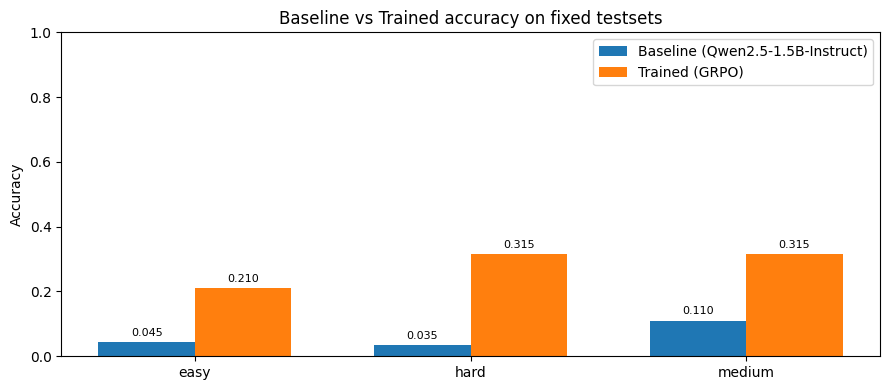

In [22]:
# --------------------------
# 7) Парные бары (baseline vs trained) — как в примере matplotlib
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
# --------------------------
names = list(testsets.keys())
base_vals = [baseline_scores[n] for n in names]
tr_vals = [trained_scores[n] for n in names]

x = list(range(len(names)))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 4))
bars1 = ax.bar([i - width/2 for i in x], base_vals, width, label="Baseline (Qwen2.5-1.5B-Instruct)")
bars2 = ax.bar([i + width/2 for i in x], tr_vals, width, label="Trained (GRPO)")

ax.set_ylabel("Accuracy")
ax.set_title("Baseline vs Trained accuracy on fixed testsets")
ax.set_xticks(x, names)
ax.set_ylim(0.0, 1.0)
ax.legend(loc="best")

def autolabel(rects):
    for r in rects:
        h = r.get_height()
        ax.annotate(
            f"{h:.3f}",
            xy=(r.get_x() + r.get_width() / 2, h),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
        )

autolabel(bars1)
autolabel(bars2)

fig.tight_layout()
plot_path = RESULTS_DIR / "paired_bars_accuracy.png"
fig.savefig(plot_path, dpi=160)
print("Saved plot:", plot_path)
plt.show()
